# Predicting Wing Lift and Drag

In [1]:
# Add path to src/CARPy, in case notebook is running locally
import os, sys, warnings
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..\\..\\..\\src")))
warnings.simplefilter("ignore")  # <-- Suppress warnings

***
## Introduction

*As a pre-requisite to this notebook, it is recommended readers first familiarise themselves with the available material on modelling aerofoils in CARPy.*

With the selection of candidate aerofoils, the performance of a 3D lifting geometry can now be estimated with CARPy.
This mapping of 2D aerofoil sections to 3D wing geometry requires:

1. WingSection, an object that dimensionalises the chord length and thickness of non-dimensional aerofoil geometries.
2. WingSections, a dictionary-like object that permits the definition of wing dihedral, sweep, and twist.

Much like the aerofoil performance prediction methods, wing performance is captured through a variety of methods in:

3. WingSolution, an object capturing basic performance coefficients of the wing.
4. CDfGudmundsson, an object that tries to estimate drag due to skin friction effects.

Inverse design methods are not supported at this time.

***
## 1) `WingSection` objects

Start with relevant imports

In [2]:
from carpy.aerodynamics.aerofoil import NewAerofoil
from carpy.aerodynamics.wing import WingSection

There are several angles or reference planes along which a wing can be sliced to produce sections or aerofoils.
CARPy wing sections are currently defined in a vertical plane parallel to the aircraft's buttock line:

In [3]:
# Instantiate geometry that will define the wing shape
naca0012 = NewAerofoil.from_method.NACA("0012")
naca2412 = NewAerofoil.from_method.NACA("2412")
naca2418 = NewAerofoil.from_method.NACA("2418")

# Defining the starboard wing section geometries
wbl_0012 = WingSection(naca0012)
wbl_2412 = WingSection(naca2412)
wbl_2418 = WingSection(naca2418)

WingSection objects are not designed for users to be able to interact with the attributes of directly, and therefore attributes should be treated as read-only.
The original aerofoil section can be recovered:

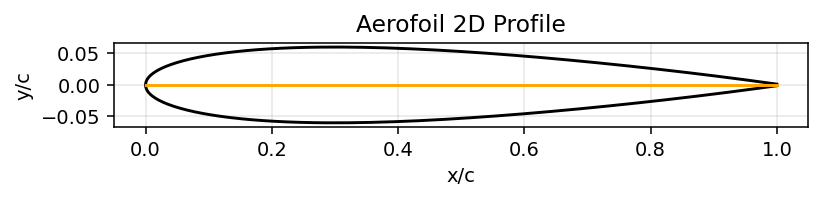

In [4]:
wbl_0012.aerofoil.show()

But it is recommended that properties of a `WingSection` are set via the `WingSections` dictionary-like object.

***
## 2) `WingSections` objects

`WingSections` objects can be thought of as a dictionary of aerofoils, created by the user, that define the 3D geometry of the wing.
Users familiar with dictionaries should be comfortable with the concept that a dictionary can have a key-value pair designated with the following syntax:
    
    >>> my_dictionary[some_key] = some_value
    
    >>> print(my_dictionary)
    {some_key: some_value}

The difference in implementation between a regular dictionary is three-fold:

1. Only integers and floats are valid keys, such that all keys lie on a one-dimensional line of real numbers.
2. The hypothetical value for a key "C" that lies between two other keys "A" and "B" is obtained by linearly interpolating between keys "A" and "B".
3. The hypothetical value for a key "D" must be extrapolated from a single neighbour "B", which actually just makes the value of "D" identical to the value at "B".

We'll demonstrate this more concretely with an example. Begin with the relevant import:

In [5]:
from carpy.aerodynamics.wing import WingSections

# Define the wing geometry at arbitrary buttock-line stations 0 and 10
conceptwing = WingSections()
conceptwing[0] = wbl_2418
conceptwing[10] = wbl_2412

Notice that each wing section defining the 3D geometry is identifiable through its location in memory (beginning with `0x`):

In [6]:
print(f"The defined wing sections are:\n{conceptwing=}")

The defined wing sections are:
conceptwing={0.0: <carpy.aerodynamics.wing._wingplanes.WingSection object at 0x00000268BE30D8B0>, 10.0: <carpy.aerodynamics.wing._wingplanes.WingSection object at 0x000002689AA3BD90>}


##### A quick detour:

To prove points 2 and 3, we'll show that users can access aerofoil geometry between two defined aerofoils (aerofoil C), and an aerofoil extrapolated from a single bounding aerofoil (aerofoil D is identical to aerofoil B):

* Here's the memory locations of each wing section object successfully evaluated:

A:0 aerofoil --> <carpy.aerodynamics.wing._wingplanes.WingSection object at 0x00000268BE30D8B0>
C:5 aerofoil --> <carpy.aerodynamics.wing._wingplanes.WingSection object at 0x00000268BE447BB0>
B:10 aerofoil --> <carpy.aerodynamics.wing._wingplanes.WingSection object at 0x000002689AA3BD90>
D:14 aerofoil --> <carpy.aerodynamics.wing._wingplanes.WingSection object at 0x000002689AA3BD90>

* Here's proof that the average of two adjacent sections [0] and [10] is the same as just taking [5]:


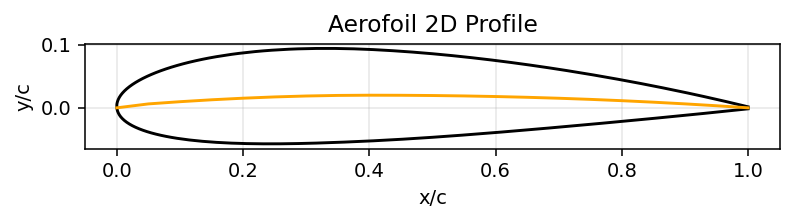

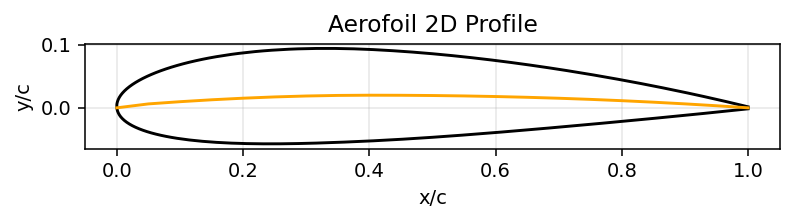


* Here's proof that section[B] and section[D] are the same section (same memory location):

(conceptwing[section_dict['B']] is conceptwing[section_dict['D']])=True


In [7]:
# To align with the explanation above, use the following keys
section_dict = {"A":0, "C":5, "B":10, "D":14}

print("* Here's the memory locations of each wing section object successfully evaluated:\n")
for (key, value) in section_dict.items():
    print(f"{key}:{value} aerofoil --> {conceptwing[value]}")
else:
    print("")

print("* Here's proof that the average of two adjacent sections [0] and [10] is the same as just taking [5]:")
aerofoil_interp_manual = (0.5 * conceptwing[0].aerofoil + 0.5 * conceptwing[10].aerofoil)  # averaging geometry
aerofoil_interp_auto = conceptwing[5].aerofoil  # interpolating geometry automatically behind the scenes

aerofoil_interp_manual.show()
aerofoil_interp_auto.show()
print("")

print("* Here's proof that section[B] and section[D] are the same section (same memory location):\n")
print(f"{(conceptwing[section_dict['B']] is conceptwing[section_dict['D']])=}")

##### End of detour, back to the notebook lesson at hand

it is necessary to specify angles of dihedral, twist, and sweep for 3D wing geometries.
Wing taper can also be optionally adjusted.

In [8]:
import numpy as np

# Define another section of the wing at another arbitrary station (in proportion to the original station definitions)
conceptwing[14] = wbl_0012

# Adjust the SI chord lengths of the wing (changing taper ratio, optional)
conceptwing[:].chord = 2.0  # Use [:] slicing to define the chord length at all stations currently defined
conceptwing[14].chord = 0.8  # The station defined at position [14] should have a custom chord length

# The dihedral angle, leading edge sweep angle, and geometric station twist angles are now specified
conceptwing[:].dihedral = np.radians(2)  # Upward dihedral on the whole wing for roll stability
conceptwing[:].sweep = np.radians(0)  # Define leading edge sweep everywhere
conceptwing[10:].sweep = np.radians(2)  # Update leading edge sweep for any stations starting at and including 10
conceptwing[14].twist = np.radians(1)  # Increased wing tip incidence, a.k.a wash-in

It doesn't look like much right now, but that's it!
You've defined a wing of arbitrary span, but definite chord length, twist, sweep, dihedral, and profile.

***
## 3) `WingSolution` objects

It is possible to carry out a rudimentary analysis of aerofoil performance in CARPy, returing `AerofoilSolution` objects.
These can be obtained through:

In [9]:
from carpy.aerodynamics.wing import PLLT  # Prandtl's lifting line theory for unswept wings
from carpy.aerodynamics.wing import HorseshoeVortex  # Span-wise horseshoe vortex method

All derivative methods of `WingSolution` have similar instantiation structures.

#### `PLLT`

PLLT is limited in analysis to unswept wings, full details in the docstring.

In [10]:
# Apply PLLT to a symmetrical wing of 12 metre span
soln0 = PLLT(sections=conceptwing, span=12, alpha=np.radians(10))

public_methods = [x for x in dir(soln0) if not x.startswith("_")]
print(f"{public_methods=}\n")

for method_name in public_methods:
    print(f"{method_name:>8} = {getattr(soln0, method_name)}")

public_methods=['AR', 'CL', 'CLalpha', 'Sref', 'b', 'delta', 'e', 'tau']

      AR = 6.569024954863637
      CL = 0.9977305340620781
 CLalpha = 4.820032635394306
    Sref = 21.9210615 m²
       b = 12. m
   delta = 0.012246573803284333
       e = 0.9879015902644445
     tau = -0.0029645916550281744


Automatic extraction of the section-wise contributions of aerofoils to the lift coefficient is not yet part of CARPy.
Also, methods for computing `WingSolution.tau` require verification and are currently considered unreliable.

#### `HorseshoeVortex`

Horseshoe Vortex methods applied to the same wing take longer, but permit the analysis of asymmetric wings, section-wise lift coefficients, and even centre of pressure.

*Users are asked to note that currently, this method assumes the centre of pressure for each vortex element sweeps by the same amount the leading edge does. This requires a fix in future, but for now, defining a leading edge sweep of 0 actually returns the performance of a wing where the section-wise centre of pressure has a sweep of 0 besides the dihedral direction (i.e. leading edge sweep varies unexpectedly).*

In [11]:
# Apply Horseshoe Vortex to a symmetrical wing of 12 metre span
soln1 = HorseshoeVortex(sections=conceptwing, span=12, alpha=np.radians(10))

public_methods = [x for x in dir(soln1) if not x.startswith("_")]
print(f"{public_methods=}\n")

for method_name in public_methods:
    print(f"{method_name:>8} = {getattr(soln1, method_name)}")

public_methods=['AR', 'CL', 'CLalpha', 'Cl', 'Sref', 'b', 'delta', 'e', 'tau', 'xyz_cp']

      AR = 6.569070920320918
      CL = 0.8672908540941726
 CLalpha = NotImplemented
      Cl = [0.00799766 0.01173675 0.01448953 0.01673368 0.01861502 0.02015819
 0.02138878 0.02235173 0.02310062 0.02370702 0.02420357 0.02461206
 0.02494807 0.02522302 0.02544532 0.02562086 0.02575224 0.02583076
 0.02567867 0.02631195 0.02466663 0.02536285 0.02579098 0.02585407
 0.02580505 0.02567664 0.02547732 0.02520688 0.02485996 0.02442671
 0.0238921  0.02323381 0.02241642 0.02134748 0.02006851 0.018535
 0.01666772 0.01443988 0.01169748 0.00795987]
    Sref = 21.92090811 m²
       b = 12. m
   delta = 0.11989621342083234
       e = 0.8929398885503883
     tau = NotImplemented
  xyz_cp = [[-5.69122580e-02 -5.77821814e+00 -1.91432140e-01]
 [-4.65645747e-02 -5.48189926e+00 -1.81084457e-01]
 [-3.62168914e-02 -5.18558038e+00 -1.70736774e-01]
 [-2.58692082e-02 -4.88926150e+00 -1.60389091e-01]
 [-1.55215249e-02 -4.59

Because `Solution` (singular) objects only evaluate at one angle of attack, the `HorseshoeVortex` method cannot by itself determine the lift slope of the wing.

***
## 4) `CDfGudmundsson` objects

CARPy provides means of estimating skin friction drag for a generic wing with surface quality comparable to that of carefully applied matte paint (see CARPy's material constants for more information).

The component of drag due to skin friction can be estimated from definitions of geometry and the relevant flight conditions:

In [12]:
from carpy.aerodynamics.wing import CDfGudmundsson
from carpy.utility import Quantity

# Make a drag prediction
drag_prediction = CDfGudmundsson(
    sections=conceptwing, span=Quantity(38.3, "ft"),  # <-- Geometry
    altitude=0, TAS=Quantity(185, "kt")  # <-- Flight conditions
)

In [13]:
print(f"A CDf of {drag_prediction.CDf} is predicted for the concept wing.")

A CDf of 0.0036277644702073903 is predicted for the concept wing.


***
## `*future*` objects

The plan is to eventually supercede `WingSolution` (singular) with `WingSolutions` (plural) objects that, for given flight conditions, conveniently interpolate lift, drag, centre of pressure, and other metrics of wing performance as a function of the wing's angle of attack.

For now, the burden is upon CARPy's users (sorry!).